# Time series forecasting with RNNs

- Source: https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

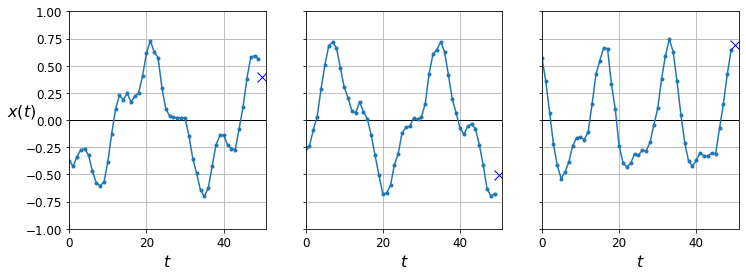

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

plt.show()

## Baselines
- Naive
- Fully connected NN

OBS: Predicting the next value only

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

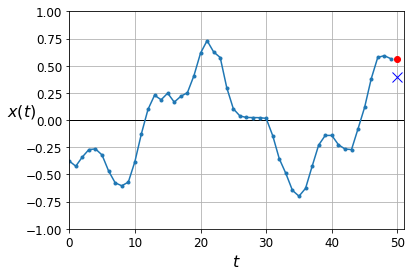

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 167us/sample - loss: 0.1008 - val_loss: 0.0552
Epoch 2/20
7000/7000 [==============================] - 0s 59us/sample - loss: 0.0388 - val_loss: 0.0270
Epoch 3/20
7000/7000 [==============================] - 0s 60us/sample - loss: 0.0206 - val_loss: 0.0160
Epoch 4/20
7000/7000 [==============================] - 1s 78us/sample - loss: 0.0132 - val_loss: 0.0115
Epoch 5/20
7000/7000 [==============================] - 0s 71us/sample - loss: 0.0103 - val_loss: 0.0097
Epoch 6/20
7000/7000 [==============================] - 1s 75us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 1s 75us/sample - loss: 0.0079 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 0s 65us/sample - loss: 0.0072 - val_loss: 0.0073
Epoch 9/20
7000/7000 [==============================] - 0s 69us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 

In [10]:
# model.evaluate(X_valid, y_valid)

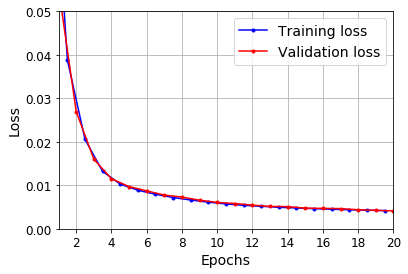

In [11]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

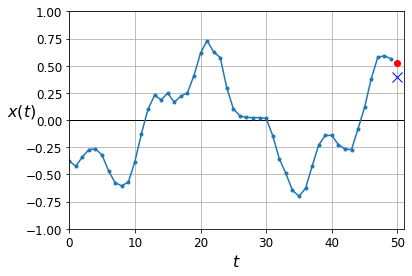

In [12]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Simplest RNN

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 704us/sample - loss: 0.0979 - val_loss: 0.0490
Epoch 2/20
7000/7000 [==============================] - 4s 519us/sample - loss: 0.0371 - val_loss: 0.0297
Epoch 3/20
7000/7000 [==============================] - 4s 563us/sample - loss: 0.0254 - val_loss: 0.0219
Epoch 4/20
7000/7000 [==============================] - 4s 518us/sample - loss: 0.0199 - val_loss: 0.0177
Epoch 5/20
7000/7000 [==============================] - 3s 499us/sample - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
7000/7000 [==============================] - 4s 608us/sample - loss: 0.0146 - val_loss: 0.0135
Epoch 7/20
7000/7000 [==============================] - 4s 567us/sample - loss: 0.0133 - val_loss: 0.0124
Epoch 8/20
7000/7000 [==============================] - 3s 481us/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 9/20
7000/7000 [==============================] - 3s 471us/sample - loss: 0.0119 - val_loss: 0.011

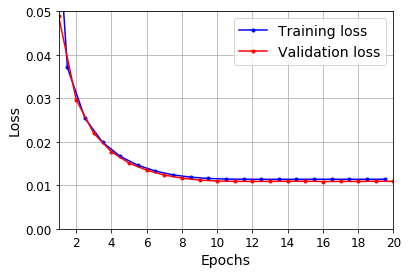

In [17]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

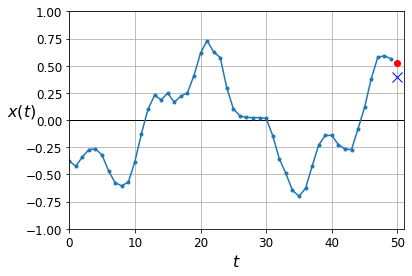

In [18]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Worst than one of the baselines -> fully connected NN

Probable reason: this RNN has only 3 parameters while the fully connected NN has more than 50. We are underfitting

## Deep RNNs

In [19]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0531 - val_loss: 0.0083
Epoch 2/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0074 - val_loss: 0.0055
Epoch 3/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0054 - val_loss: 0.0050
Epoch 4/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0047 - val_loss: 0.0041
Epoch 5/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0044 - val_loss: 0.0041
Epoch 6/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0041 - val_loss: 0.0040
Epoch 7/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0038 - val_loss: 0.0035
Epoch 8/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0038 - val_loss: 0.0039
Epoch 9/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 1

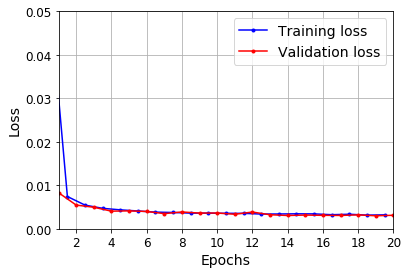

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

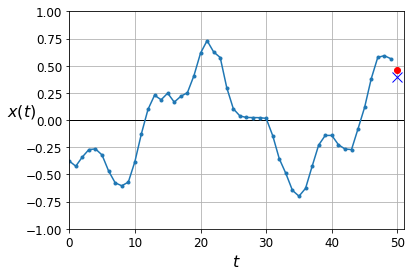

In [21]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

The Deep RNNs surpassed the fully connected NN

Creating an RNN that predicts all 10 next values at once

In [22]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0663 - val_loss: 0.0312
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0265 - val_loss: 0.0214
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0187 - val_loss: 0.0203
Epoch 4/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0151 - val_loss: 0.0157
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0139 - val_loss: 0.0127
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0127 - val_loss: 0.0114
Epoch 7/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0119 - val_loss: 0.0118
Epoch 8/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0114 - val_loss: 0.0106
Epoch 9/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0110 - val_loss: 0.0116
Epoch 10/20
70

In [24]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

In [25]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

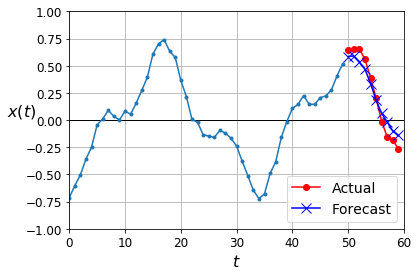

In [26]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Create an RNN that predicts the next 10 steps at each time step. 

In [27]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [28]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0502 - last_time_step_mse: 0.0392 - val_loss: 0.0422 - val_last_time_step_mse: 0.0309
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0403 - last_time_step_mse: 0.0293 - val_loss: 0.0361 - val_last_time_step_mse: 0.0274
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0409 - last_time_step_mse: 0.0343 - val_loss: 0.0396 - val_last_time_step_mse: 0.0327
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0334 - last_time_step_mse: 0.0238 - val_loss: 0.0296 - val_last_time_step_mse: 0.0185
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0289 - last_time_step_mse: 0.0181 - val_loss: 0.0265 - val_last_time_step_mse: 0.0155
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0257 - last_time_step_mse: 0.0143 - val_l

In [30]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

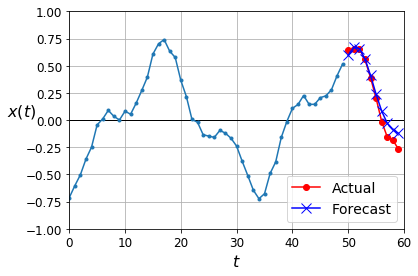

In [31]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()